# 05 훈련 노하우를 배웁니다

이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/do-it-dl/blob/master/Ch05.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/do-it-dl/blob/master/Ch05.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 05-1 검증 데이터를 준비합니다

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [3]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                            test_size=0.2, random_state=42)

In [4]:
from sklearn.linear_model import SGDClassifier

In [5]:
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

InvalidParameterError: The 'loss' parameter of SGDClassifier must be a str among {'perceptron', 'squared_hinge', 'huber', 'squared_epsilon_insensitive', 'squared_error', 'hinge', 'epsilon_insensitive', 'modified_huber', 'log_loss'}. Got 'log' instead.

In [6]:
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [8]:
print(len(x_train), len(x_val))

364 91


In [9]:
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

InvalidParameterError: The 'loss' parameter of SGDClassifier must be a str among {'perceptron', 'squared_hinge', 'huber', 'squared_epsilon_insensitive', 'squared_error', 'hinge', 'epsilon_insensitive', 'modified_huber', 'log_loss'}. Got 'log' instead.

['mean perimeter' 'mean area']


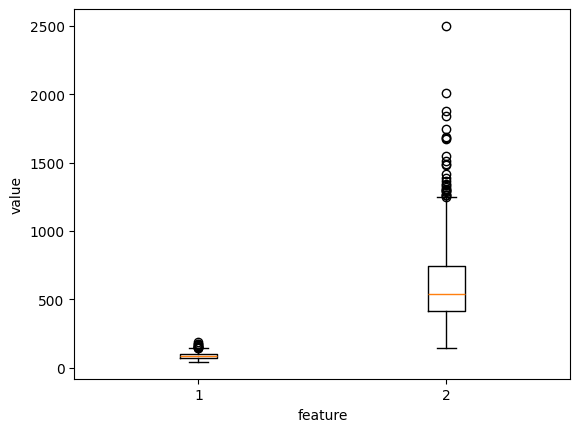

In [10]:
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [11]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b    # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err          # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())       # 가중치를 기록합니다.
        np.random.seed(42)                         # 랜덤 시드를 지정합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다.
            loss = 0
            # 인덱스를 섞습니다
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                # 그래디언트에서 페널티 항의 미분 값을 더합니다
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad         # 가중치 업데이트
                self.b -= self.lr * b_grad         # 절편 업데이트
                # 가중치를 기록합니다.
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y) + self.reg_loss())
            # 검증 세트에 대한 손실을 계산합니다
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) >= 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])     # 정방향 계산
            a = self.activation(z)         # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

In [12]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

np.float64(0.9120879120879121)

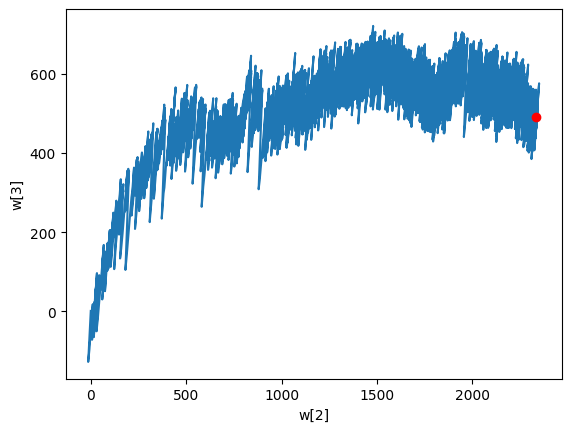

In [13]:
w2 = []
w3 = []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

In [14]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

In [15]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)

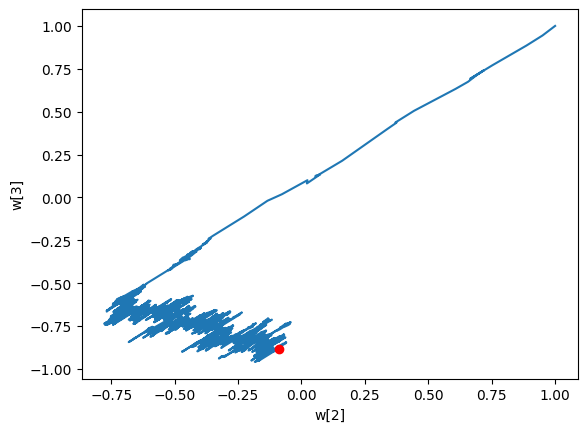

In [16]:
w2 = []
w3 = []
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

In [17]:
layer2.score(x_val, y_val)

np.float64(0.37362637362637363)

In [18]:
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std

In [19]:
layer2.score(x_val_scaled, y_val)

np.float64(0.967032967032967)

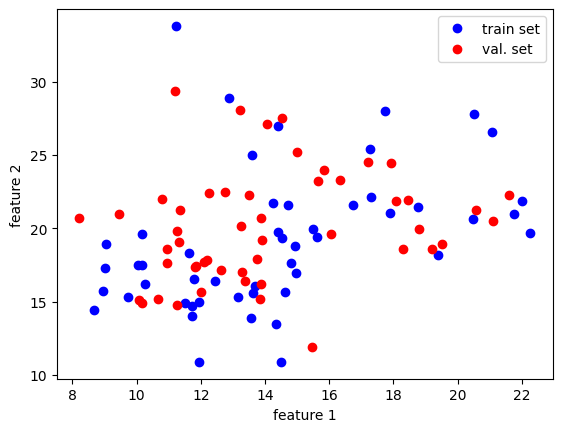

In [20]:
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

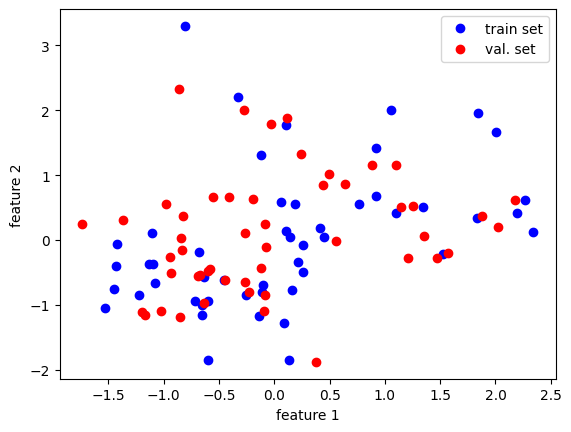

In [21]:
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

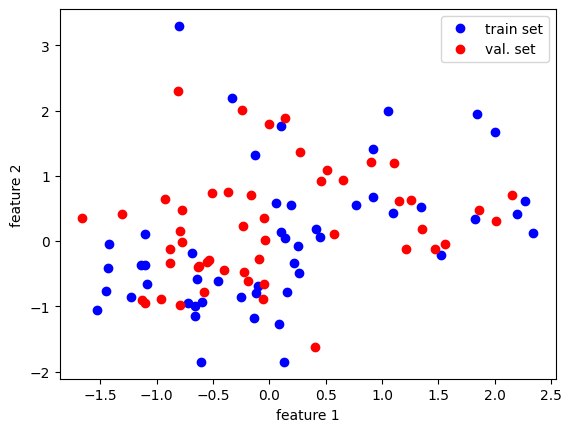

In [33]:
x_val_scaled = (x_val - train_mean) / train_std

plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

In [34]:
layer2.score(x_val_scaled, y_val)

np.float64(0.967032967032967)

## 05-2 과대적합과 과소적합을 알아봅니다

In [24]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

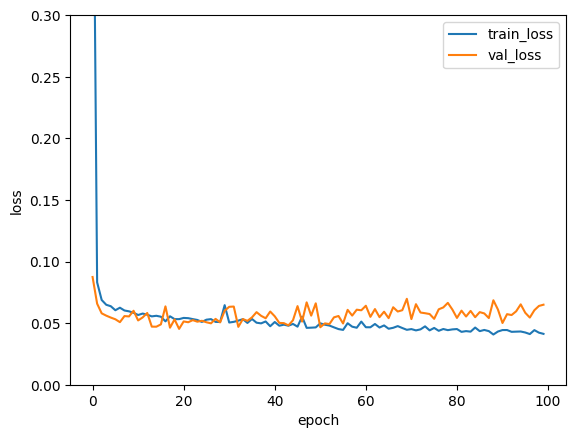

In [25]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [26]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)

np.float64(0.989010989010989)

## 05-3 규제를 알아봅니다

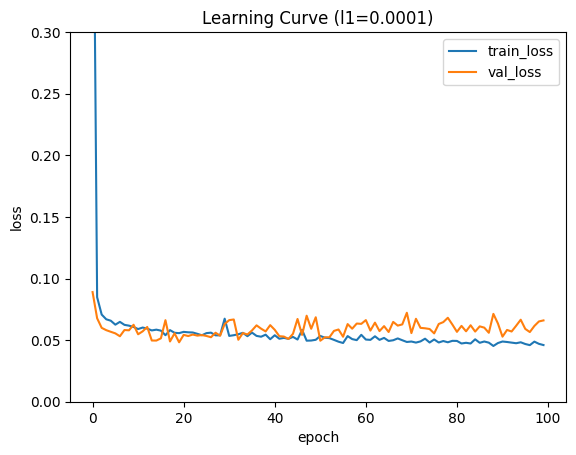

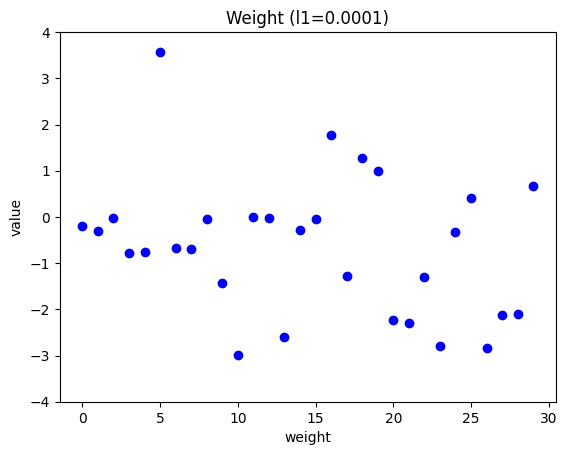

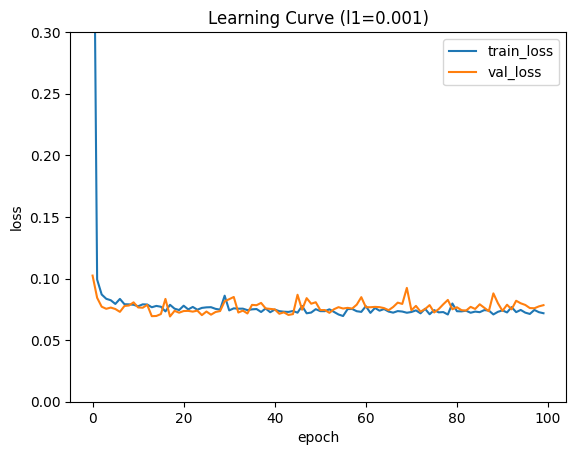

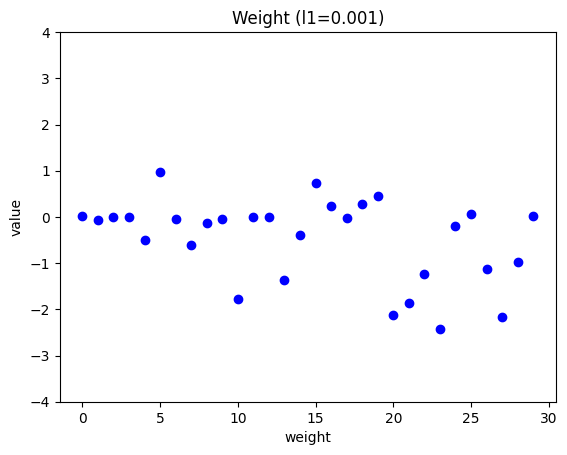

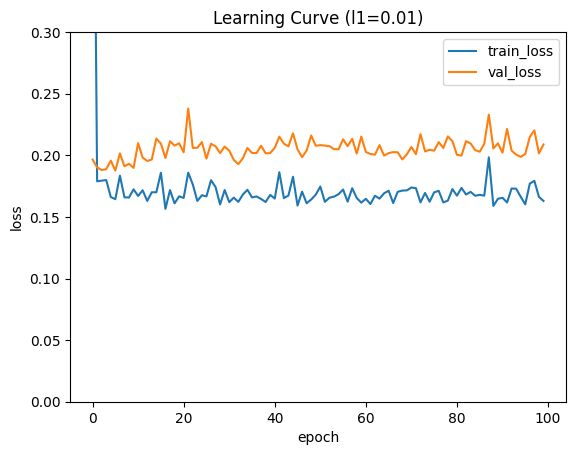

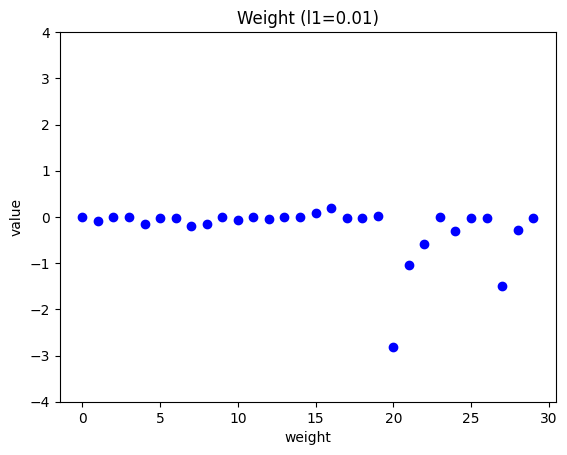

In [27]:
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
    lyr = SingleLayer(l1=l1)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l1={})'.format(l1))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l1={})'.format(l1))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

In [28]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled, y_val)

np.float64(0.989010989010989)

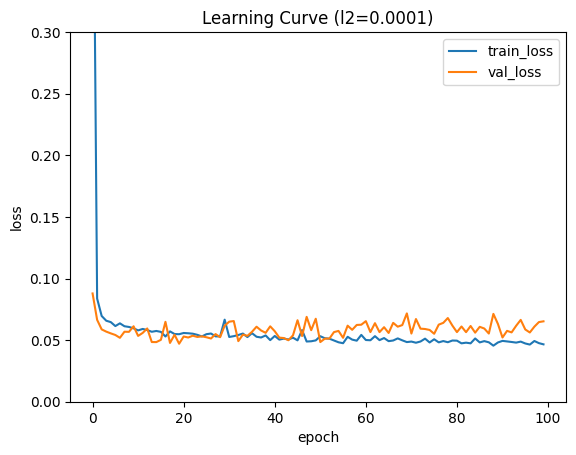

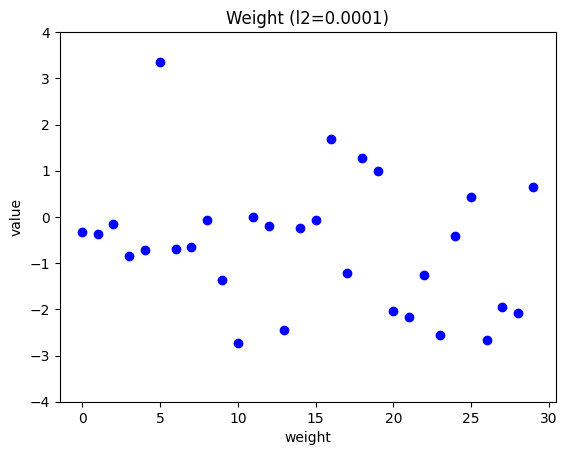

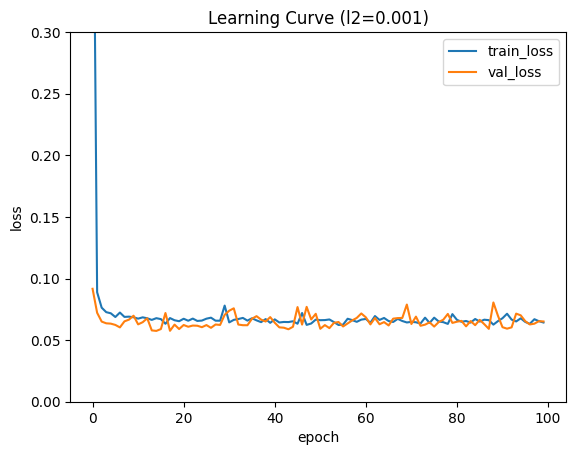

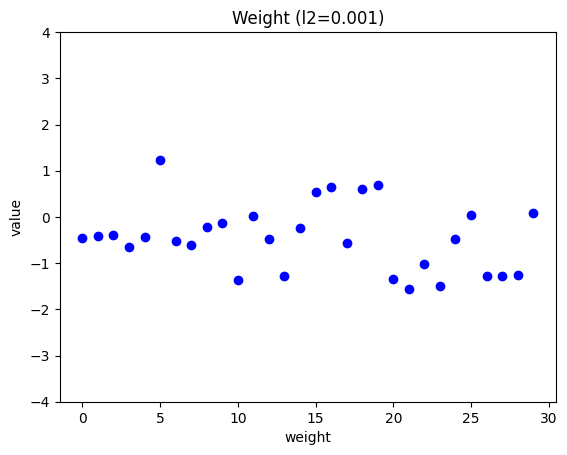

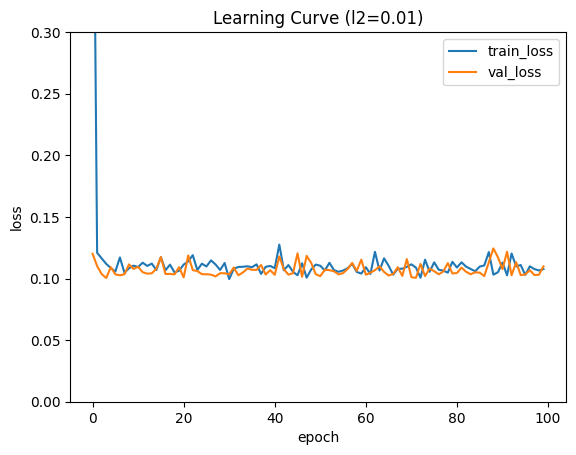

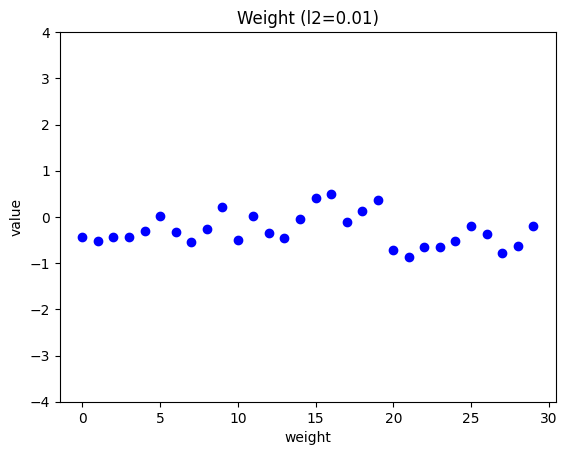

In [29]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
    lyr = SingleLayer(l2=l2)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l2={})'.format(l2))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l2={})'.format(l2))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

In [30]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

np.float64(0.989010989010989)

In [31]:
np.sum(layer6.predict(x_val_scaled) == y_val)

np.int64(90)

In [32]:
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

InvalidParameterError: The 'loss' parameter of SGDClassifier must be a str among {'perceptron', 'squared_hinge', 'huber', 'squared_epsilon_insensitive', 'squared_error', 'hinge', 'epsilon_insensitive', 'modified_huber', 'log_loss'}. Got 'log' instead.

## 05-4 교차 검증을 알아봅니다

In [ ]:
validation_scores = []

In [ ]:
k = 10
bins = len(x_train_all) // k

for i in range(k):
    start = i*bins
    end = (i+1)*bins
    val_fold = x_train_all[start:end]
    val_target = y_train_all[start:end]
    
    train_index = list(range(0, start))+list(range(end, len(x_train_all)))
    train_fold = x_train_all[train_index]
    train_target = y_train_all[train_index]
    
    train_mean = np.mean(train_fold, axis=0)
    train_std = np.std(train_fold, axis=0)
    train_fold_scaled = (train_fold - train_mean) / train_std
    val_fold_scaled = (val_fold - train_mean) / train_std
    
    lyr = SingleLayer(l2=0.01)
    lyr.fit(train_fold_scaled, train_target, epochs=50)
    score = lyr.score(val_fold_scaled, val_target)
    validation_scores.append(score)

print(np.mean(validation_scores))

0.9777777777777779


In [ ]:
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10)
print(np.mean(scores['test_score']))

0.850096618357488


In [ ]:
type(scores)

dict

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)
print(np.mean(scores['test_score']))

0.9694202898550724


In [ ]:
print(np.mean(scores['train_score']))

0.9875478561631581
